# Introduction

March Madeness is a folk name of basketball tournament, the elimination series of NCAA always begins on March so it's called March Madness. In this report, datasets include both regular session and March Madness from the aspects of games, players and events on court. As a famous basketball tuornament, March Madness contains lots of data with completeness in 30 years. A comprehensive data mining based on these data can help management of the tournament, teams and conferences, which is imperative.

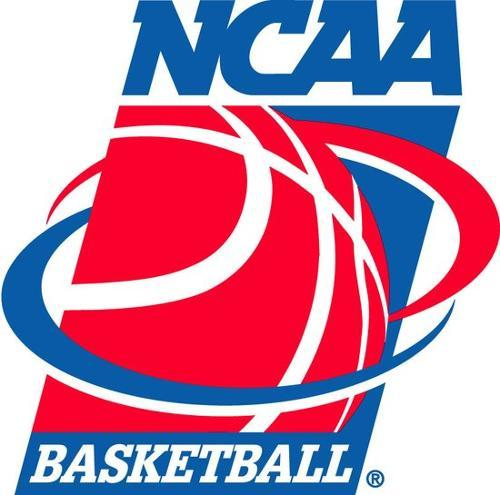

Every year more than 300 teams through a complex process of regualr session compete for 64 spots during the March Madenss games, these 64 spots called bracket. The 64 teams selected from all called seeds. NCAA has been divided into 4 regions: east, west, north and south. Each regoin has some team conferences. Teams are selected by in-conference games and regional elimination-games.Then the outstanding teams from 4 regions get the spot and are ranked by their performance and according seeds. Finally through elimination series 64 teams decide the title(champion).

Thrilling knockout rules make results of tournament less predictable and helps gain unreplacble popularity. Despite the great uncertainty of games, intriguing findings are hidden behind the dataset provided, which is tasked for us. In this notebook, we first conduct visual explorations, and then dig into issues that interest us.

Before analysis works, we imported some needed packages, including numpy, pandas and some packages that are used for data cleaning and visualization.

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import networkx as nx
import random
import seaborn as sns

# Topic 1: Time changes NCAA

In this part we are going to show some changes of basic index as time went by. Time changes NCAA and playing style of it.

Calculated annual average *game sum-points* each year, the first figure shows the change of sum points. 

Combined with history of basketball, we assumed that the first rise results from preference of big-size competetion around the basket, the second rise recently results from a small-ball revolution.
At most years the line goes down, which suggests the higher level of defense in the next years after a new strategy appeared.

In [ ]:
nc=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv",encoding='utf-8')
nc["sum_score"]=nc.WScore+nc.LScore
nc["score_distance"]=nc.WScore-nc.LScore
n_points=pd.DataFrame()
group_by=nc.groupby(by=["Season"])
n_points["avr_sumscore"]=group_by["sum_score"].mean()
n_points["avr_scoredistance"]=group_by["score_distance"].mean()
n_points["Season"]=range(1985,2020)
rc=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv",encoding='utf-8')
rc["sum_score"]=rc.WScore+rc.LScore
rc["score_distance"]=rc.WScore-rc.LScore
r_points=pd.DataFrame()
group_by=rc.groupby(by=["Season"])
r_points["avr_sumscore"]=group_by["sum_score"].mean()
r_points["avr_scoredistance"]=group_by["score_distance"].mean()
r_points["Season"]=range(1985,2020)

plt.figure(figsize=(16,8))
plt.xlim(1984,2020)
plt.xticks(np.arange(1985, 2020, 1))
plt.title("Annual average sum points of games")
plt.xlabel("Season")
plt.ylabel("Points")
plt.plot(n_points["Season"],n_points["avr_sumscore"],label="Mad March",color='blue')
plt.scatter(n_points["Season"],n_points["avr_sumscore"],color='blue')
plt.plot(r_points["Season"],r_points["avr_sumscore"],label="Regular",color='red')
plt.scatter(r_points["Season"],r_points["avr_sumscore"],color='red')
plt.legend(["March Madness","Regular"])
plt.grid(c='gray')
plt.show()

Calculated the annual average *score differential of game* each year, this figure shows change of *score differential of game*. 

Score differential equals to the points win-team made minus the points lost-team made each game, which can provide a description of team strength distribution. 

Surprisingly, the regular session shows a stability while the competetion during the march madenss is more fluctuated. It suggests that in some years the good and bad are intermingled in the 64 selected. And the selection rules of those years are not so valid, since 64 selected teams experienced a large range of team strength than the entirety of hundreds.

In [ ]:
plt.figure(figsize=(16,8))
plt.xlim(1984,2020)
plt.xticks(np.arange(1985, 2020, 1))
plt.title("Annual average score differential")
plt.xlabel("Season")
plt.ylabel("Score Differential")
plt.plot(n_points["Season"],n_points["avr_scoredistance"],label="Mad March",color='blue')
plt.scatter(n_points["Season"],n_points["avr_scoredistance"],color='blue')
plt.plot(r_points["Season"],r_points["avr_scoredistance"],label="Regular",color='red')
plt.scatter(r_points["Season"],r_points["avr_scoredistance"],color='red')
plt.legend(["March Madness","Regular"])
plt.grid(c='black')
plt.show()

To clarify the reason in some years the score distance of March Madness is higher, we use boxplotS to research if there is a significant difference of score differential between March Madness and Regular games in those years. 

(The green triangle represents the median and the red line represents the average)

The boxplot show that there are few games with significantly high score differential each year. So we assert in some years, range of team strength of 64 teams in March Madness has more variation than of all 300 or more teams joining in the regular seasons. 

In [ ]:
teaminfo=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MTeams.csv",encoding='utf-8')
def outlierteams(yearlist):
    fig = plt.figure(figsize=(36,6))
    i=1
    for item in yearlist:
        nc_year=nc[nc.Season==item]
        nc_year=nc_year[["WTeamID","LTeamID","score_distance"]]
        rc_year=rc[rc.Season==item]
        rc_year=rc_year[["WTeamID","LTeamID","score_distance"]]
        ax1 = fig.add_subplot(1,9,i)
        ax1.grid(axis='both',c='white')
        ax1.set_ylabel("Score Distance")
        ax1.set_title("Score distance in "+str(item))
        ax1.boxplot([[x for x in list(nc_year.score_distance)],[x for x in list(rc_year.score_distance)]],showfliers=False,showmeans=True,widths = 0.6)
        ax1.set_xlabel("March Madness     Regular")
        ax1.set_xticks([])
        i=i+1
    plt.show()
outlierteams([1993,1996,1999,2001,2008,2009,2013,2016,2019])

The five basic indexes of a basketball game are: Points, Rebounds, Assists, Steals and Blocks. 

After data uniformization, calculated the 5 annual indexes from 2003 to 2019 are shown below. 

In all, this figure shows the collapse of the traditional body collision and the trend of new small-ball revolution. 
Most indexes undergo a decline 10 years ago, but also experience a rise in recent years. 


In [ ]:
ncaadetail=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv",encoding='utf-8')
ncaadetail["sumpoints"]=ncaadetail.WScore+ncaadetail.LScore
ncaadetail["sumrebounds"]=ncaadetail.WOR+ncaadetail.WDR+ncaadetail.LOR+ncaadetail.LDR
ncaadetail["sumblocks"]=ncaadetail.WBlk+ncaadetail.LBlk
ncaadetail["sumsteals"]=ncaadetail.WStl+ncaadetail.LStl
ncaadetail["sumast"]=ncaadetail.WAst+ncaadetail.LAst

avr_ncaa=pd.DataFrame()
group_by=ncaadetail.groupby(by=["Season"])
avr_ncaa["avr_point"]=group_by["sumpoints"].mean()
avr_ncaa["avr_rebound"]=group_by["sumrebounds"].mean()
avr_ncaa["avr_block"]=group_by["sumblocks"].mean()
avr_ncaa["avr_steal"]=group_by["sumsteals"].mean()
avr_ncaa["avr_ast"]=group_by["sumast"].mean()
avr_ncaa["Season"]=range(2003,2020)
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
avr_ncaa["avr_point"]=avr_ncaa[['avr_point']].apply(max_min_scaler)
avr_ncaa["avr_rebound"]=avr_ncaa[['avr_rebound']].apply(max_min_scaler)
avr_ncaa["avr_block"]=avr_ncaa[['avr_block']].apply(max_min_scaler)
avr_ncaa["avr_steal"]=avr_ncaa[['avr_steal']].apply(max_min_scaler)
avr_ncaa["avr_ast"]=avr_ncaa[['avr_ast']].apply(max_min_scaler)


feature = np.array([u'points', u'rebounds', u'blocks',u'steals',u'assist']) 
nAttr=5
i=1
fig=plt.figure(figsize=(24,20),facecolor="white")
plt.axis('off')
plt.grid()
for item in avr_ncaa.iterrows():
    values=np.array(list(item[1])[:-1])
    angles=np.linspace(0,2*np.pi,nAttr,endpoint=False)
    values=np.concatenate((values,[values[0]]))
    angles=np.concatenate((angles,[angles[0]]))  
    ax1 = fig.add_subplot(4,5,i,polar=True)
    ax1.set_title('Year '+str(int(item[1][-1])),loc="left")
    ax1.plot(angles,values,'bo-',color='g',linewidth=2)
    ax1.fill(angles,values,facecolor='g',alpha=0.2)
    ax1.set_thetagrids(angles * 180/np.pi, feature)
    ax1.grid(True)
    ax1.set_theta_zero_location(loc='E') 
    i=i+1

Calculated the average total goals made and assists per game as shown below.

Sum of goals rises up in 2017 and goes down recently while num of Assists doesn't fluctuate so much. 
Basically, assists do not possess a high postion in goals. Only about 1/3 of goals accompanies according to assists in NCAA basketball games. From 2013-2019 the ratio of assists does not vary too much, suggests the stability of status of assists in NCAA basketball games. 

In [ ]:
ncaadetail["sumgoals"]=ncaadetail.WFGM+ncaadetail.LFGM+ncaadetail.WFGM3+ncaadetail.LFGM3+ncaadetail.WFTM+ncaadetail.LFTM
ncaadetail["sumattempts"]=ncaadetail.WFGA+ncaadetail.LFGA+ncaadetail.WFGA3+ncaadetail.LFGA3+ncaadetail.WFTA+ncaadetail.LFTA
ncaadetail["3pointers"]=ncaadetail.WFGM3+ncaadetail.LFGM3
ncaadetail["3pointersattempts"]=ncaadetail.WFGA3+ncaadetail.LFGA3
ncaadetail["sumast"]=ncaadetail.WAst+ncaadetail.LAst
group_by=ncaadetail.groupby(by=["Season"])
avr_ncaa["avr_ast"]=group_by["sumast"].mean()
avr_ncaa["avr_goal"]=group_by["sumgoals"].mean()
avr_ncaa["avr_attempts"]=group_by["sumattempts"].mean()
avr_ncaa["avr_3pointers"]=group_by["3pointers"].mean()
avr_ncaa["avr_3pointersattempts"]=group_by["3pointersattempts"].mean()
avr_ncaa["avr_3pointersratio"]=avr_ncaa["avr_3pointers"]/avr_ncaa["avr_3pointersattempts"]
avr_ncaa["Season"]=range(2003,2020)
avr_ncaa["avr_astratio"]=avr_ncaa["avr_ast"]/avr_ncaa["avr_goal"]
avr_ncaa["avr_3pointsratio"]=avr_ncaa["avr_3pointersattempts"]/avr_ncaa["avr_attempts"]

plt.figure(figsize=(10,8))
plt.xlim(2002,2020)
my_x_ticks = np.arange(2002, 2020, 1)
plt.xticks(my_x_ticks)
plt.ylim(0,120)
plt.title("Annual average sum of ast and goals of NCAA")
plt.xlabel("Season")
plt.ylabel("Number of goals/asts")
plt.bar(x=list(avr_ncaa["Season"]),height=list(avr_ncaa["avr_goal"]),label="goals",width=0.4)
plt.bar(x=list(avr_ncaa["Season"]),height=list(avr_ncaa["avr_ast"]),label="ast",width=0.4)
plt.legend(["goals","ast"],loc = 'upper left')
plt.grid()
plt.show()

 Calculated annual average num of 3-pointers goals and attempts, counted the ration of 3-pointers as the proportion of 3-pointers in all attempts of goals. 

The 3-pointers made-attempts ratio becomes higher in these years, which suggests the higher status of 3-pointers in game strategies.
The hit rate of 3-pointers fluctuates around 1/3, but only 20%-25% of attempts in NCAA games aims at 3-pointers. 

In [ ]:
plt.figure(1,figsize=(20,16))
plt.subplot(121)
plt.xticks(np.arange(0, 60, 5))
plt.yticks(np.arange(2002, 2020, 1))
plt.ylim(2002,2020)
plt.title("Annual average 3-pointer made and attempts of NCAA")
plt.ylabel("Season")
plt.xlabel("Number of 3-pointer made/attempts")
plt.barh(list(avr_ncaa["Season"]),list(avr_ncaa["avr_3pointersattempts"]),label="3-pointer attempts")
plt.barh(list(avr_ncaa["Season"]),list(avr_ncaa["avr_3pointers"]),label="3-pointer made")
plt.legend(["attempts","3 points"],loc = 'upper left')
plt.subplot(122)
plt.xlim(2002,2020)
plt.yticks(np.arange(0, 0.3,0.05))
plt.xticks(np.arange(2002, 2020,1))
plt.ylim(0,0.3)
plt.title("Ratio of 3-poniters attempts")
plt.xlabel("Season")
plt.ylabel("Ratio of 3-pointers attempts")
plt.bar(list(avr_ncaa["Season"]),list(avr_ncaa["avr_3pointsratio"]),label="attempts")
plt.show()

# Topic 2: Basics about tournament

In this part we provide some basic inforamtion about NCAA teams like team age, game distribution and strong teams list.

Based on game data from 2010 till now, each state has averagely held 19 games during Madeness March. The state of Ohio held 70 games as the most popular game-host, while Minnesota and New Jersey almost held no games.

In [ ]:
gamecity=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MGameCities.csv",encoding='utf-8')
city_state=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/Cities.csv",encoding='utf-8')
gamecity=pd.merge(gamecity,city_state,"left",on="CityID")
gamecityncaa=gamecity[gamecity.CRType=="NCAA"].copy()
gamecityncaa["id"]=range(1,668)
games_state=pd.DataFrame()
games_state=gamecityncaa.groupby(by=["State"])["id"].count().reset_index(name="count")

plt.figure(figsize=(15,12))
plt.bar(games_state["State"],games_state["count"],color='red')
plt.title("Races State Distribution")
plt.axhline(y=games_state["count"].mean(),color="blue")
plt.axhline(y=games_state["count"].max(),color="yellow")
plt.ylabel("Num of Games Hold",fontsize=15)
plt.xlabel("State",fontsize=15)
plt.annotate('average: 19', xy=(10,19.5), xytext=(8,25),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('max: 70', xy=(7,70), xytext=(4,65),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(c='gray')
plt.show()

Calculated top4 teams each year and count the time each team stepping into senifinal. We found 13 teams which had stepped into senifinal of March Madness at least 4 times. AMong themDuck and North Carolina are the best, which deserve special attention as a rival.

In [ ]:
ncaacompacttop4=nc[nc.DayNum==152].copy()
top4=pd.DataFrame()
year=[]
teams=[]
for row in ncaacompacttop4.iterrows():
    year.append(row[1][0])
    year.append(row[1][0])
    teams.append(row[1][2])
    teams.append(row[1][4])

top4["Season"]=year
top4["TeamID"]=teams

teaminfo=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MTeams.csv",encoding='utf-8')
top4=pd.merge(top4,teaminfo,"left", on="TeamID")
top4teams=top4.groupby(["TeamName"])["TeamID"].count().reset_index(name="count")
top4teams=top4teams[top4teams["count"]>=4]

plt.figure(figsize=(10,8))
plt.xlim(0,15)
plt.title("Strong Teams")
plt.ylabel("Teams")
plt.xlabel("Final Four times")
plt.barh(list(top4teams["TeamName"]),list(top4teams["count"]))
plt.show()

 Most team(75%) join in the tournament at the first year of NCAA, only one fourth joined after the second season.

In [ ]:
teaminfo["age"]=teaminfo.LastD1Season-teaminfo.FirstD1Season
teamage=teaminfo.groupby(["age"])["TeamID"].count().reset_index(name="count")

teamage['panduan'] = teamage['age'].apply(lambda x: 1 if x==35 else 0)
teamage=teamage.groupby(["panduan"])["count"].sum().reset_index(name="count")
teamage.panduan=["Less than 35 years","35 years"]

plt.figure(figsize=(10,8))
plt.pie(teamage['count'],labels=teamage.panduan,autopct='%1.1f%%',startangle=150,explode=[0.1,0],shadow=True)
plt.legend(loc="upper right",fontsize=10,borderaxespad=0.3)
plt.title("Team age")
plt.axis('equal')
plt.show()  

The heatmap shows the area preference of actions on court. 

The foul mostly occurs at area 1, 2 and 13, suggesting that the main reason of fouls are usually competetion under the basket and passing ball at half court. 

Turnover always happens at 2, 4, 6, 10, 13 areas, suggesting turnover always accompanies with filed goal attempts or passing ball at half court.

In [ ]:
events2015=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2015.csv",encoding='utf-8')
events2016=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2016.csv",encoding='utf-8')
events2017=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2017.csv",encoding='utf-8')
events2018=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2018.csv",encoding='utf-8')
events2019=pd.read_csv(f"../input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MEvents2019.csv",encoding='utf-8')
events=pd.concat([events2015,events2016,events2017,events2018,events2019])
events_hasarea=events[events.Area!=0]
columns=["foul","made2","made3","miss2","miss3","turnover"]
events_issues=pd.DataFrame(index=range(1,14),columns=[])
for item in columns:
    events_issue=events_hasarea[events_hasarea.EventType==item]
    events_issue=pd.DataFrame(events_issue.groupby(by=["Area"]).size(),columns=[item])
    events_issues=pd.concat([events_issues,events_issue],sort=True,axis=1)
    
events_issues=events_issues.apply(lambda x: round((x - np.min(x)) / (np.max(x) - np.min(x)),2))
events_issues=events_issues.fillna(0)

fig=plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
im = ax.imshow(events_issues, cmap=plt.cm.summer)
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(len(events_issues.columns)))
ax.set_yticks(np.arange(len(events_issues.iloc[:,0])))
ax.set_xticklabels(events_issues.columns)
ax.set_yticklabels(events_issues.index) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)
fig.colorbar(im,pad=0.03) 
ax.set_title("Heatmap for areas and actions",fontsize=16) 
plt.grid()
plt.show()

# Topics 3: Networks of regular games

Using the data of regular games record in 2019, we figured the network of team-team game in a way of times that two teams playing with each other during the whole year. For example, if team A has played with team B in 2019 3 times, then link an edge from node A to node B weighted as 3. 

The left net removes edge weights less than 2. So it acts more like a net of conferences of all teams. The right one is moer complex with all edges and deserves more research, we always refer to this net when mention "the net" below.

In [ ]:
regular_19=rc[rc.Season==2019]
regular_19=regular_19.loc[:,["Season",'DayNum','WTeamID','LTeamID']]
regular_19_net=pd.DataFrame(regular_19.groupby(by=['WTeamID','LTeamID']).size(),columns=["num_of_games"])
allwteams=list(set(regular_19.WTeamID))
alllteams=list(set(regular_19.LTeamID))
allteams=list(set(allwteams+alllteams))
lst=[]
nodes=[]
for item in regular_19_net.iterrows():
    if item[1][0]>=2:
        lst.append((item[0][0],item[0][1],item[1][0]))
        nodes.append(item[0][0])
        nodes.append(item[0][1])
nodes=list(set(nodes))
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(lst)
plt.figure(figsize=(20,12))             
plt.subplot(121)           
nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G),with_labels=False,edge_color='black',node_size=10,alpha=0.5,node_shape='s',width=0.4)
plt.title("In Conference games")
plt.legend(["Team"],loc='upper left')

lst=[]
nodes=[]
for item in regular_19_net.iterrows():
    if item[1][0]>=0:
        lst.append((item[0][0],item[0][1],item[1][0]))
        nodes.append(item[0][0])
        nodes.append(item[0][1])
nodes=list(set(nodes))
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(lst)
plt.subplot(122)               
nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G),with_labels=False,edge_color='black',node_size=10,alpha=0.5,node_shape='s',width=0.2)
plt.legend(["Team"],loc='upper left')
plt.title("All games")
plt.show()

The degree distribution figure shows that a node in the net usually has 10-20 edges accessible to others. After removing teams in the same conference, a team in NCAA usually has around 10 friend teams that frequently play with.

In [ ]:
degree=nx.degree_histogram(G)
x=range(len(degree))
y=[z/float(sum(degree))for z in degree]
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree-distribution")
plt.loglog(x,y,color="blue",linewidth=2)
plt.show()

The degree assortativity coefficient shows the preference of nodes to generate new edges. As the figure shows, teams are more likely to play with teams that tend to play more with new teams. That's different from social network like facebook, suggesting higher effciency of information transition and a possibility of small world.

In [ ]:
dac=nx.degree_assortativity_coefficient(G)
x=list(G.degree())
y=nx.average_neighbor_degree(G)
x=[item[1] for item in x]
y=[item[1] for item in y.items()]
plt.xlabel("Degree")
plt.ylabel("Average-neighbor degree")
plt.title("degree_assortativity")
plt.scatter(x,y,color="blue",s=1)
plt.show()
print("degree assortativity coefficient of the network："+str(dac))

 The boxplots show the clustering coefficient and average shortest path length. Compared with 50 random-made networks using same nodes and setting random edges, the real net has a significant higher clustering coefficient and a lower average shortest path length. Therefore, the net of games of NCAA can be proved as a small world. Teams are active and aggressive in this time, it's easy to find a team to play during regular session.

In [ ]:
cc=nx.average_clustering(G)
asd=nx.average_shortest_path_length(G,weight='yes')

cc_random=[]
asd_random=[]
for i in range(50):
    lst1=[(a,b,random.randint(1,6) if random.choice([0,1]) else 0) for a,b,c in lst]
    lst1=[item for item in lst1 if item[2]!=0]
    G_random=nx.Graph()
    G_random.add_nodes_from(nodes)
    G_random.add_weighted_edges_from(lst1)
    cc_random.append(nx.average_clustering(G_random))
    asd_random.append(nx.average_shortest_path_length(G_random,weight='yes'))

plt.figure(figsize=(9,7))
plt.subplot(121)
plt.boxplot(cc_random)
plt.scatter(x=1,y=cc,color='blue',s=2)
plt.annotate("NCAA 2019",xy=(1,cc),xytext=(0.5,cc-0.03),arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim()
plt.grid(c='white')
plt.ylabel("clustering coefficients")

plt.subplot(122)
plt.boxplot(asd_random)
plt.scatter(x=1,y=asd,color='red',s=2)
plt.annotate("NCAA 2019",xy=(1,asd),xytext=(1.3,asd+0.1),arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim()
plt.ylabel("average shortest distance")
plt.grid(c='white')
plt.show()

To clarify if the net was aged, this figure shows the node(team) age VS the probability making new edges of the node. As the figure shows, it looks like the front part of DM aged model curve. It shows the figure is middle-aged and tends to be stable in the next time. But now it's still active and available for nodes to make new edges with others.

In [ ]:
def time_with_newedges(years):
    results=[]  
    dict_teamrivals={}
    for year in years:
        regular_year=rc[rc.Season==year]
        regular_year=regular_year.loc[:,["Season",'DayNum','WTeamID','LTeamID']]
        lastyear=year-1
        regular_lastyear=rc[rc.Season==lastyear]
        regular_lastyear=regular_lastyear.loc[:,["Season",'DayNum','WTeamID','LTeamID']]


        allwteams=list(set(regular_year.WTeamID))
        alllteams=list(set(regular_year.LTeamID))
        allteams=list(set(allwteams+alllteams))
        num_teams_year=len(allteams)


        regular_year_net=pd.DataFrame(regular_year.groupby(by=['WTeamID','LTeamID']).size(),columns=["num_of_games"])
        lst=[]
        nodes=[]
        for item in regular_year_net.iterrows():
            lst.append((item[0][0],item[0][1],item[1][0]))
            nodes.append(item[0][0])
            nodes.append(item[0][1])
        nodes=list(set(nodes))
        G1=nx.Graph()
        G1.add_nodes_from(nodes)
        G1.add_weighted_edges_from(lst)


        regular_lastyear_net=pd.DataFrame(regular_lastyear.groupby(by=['WTeamID','LTeamID']).size(),columns=["num_of_games"])
        lst=[]
        nodes=[]
        for item in regular_lastyear_net.iterrows():
            lst.append((item[0][0],item[0][1],item[1][0]))
            nodes.append(item[0][0])
            nodes.append(item[0][1])
        nodes=list(set(nodes))
        G2=nx.Graph()
        G2.add_nodes_from(nodes)
        G2.add_weighted_edges_from(lst)


        for item in dict(G1.degree()).keys():
            teambornyear=int(teaminfo[teaminfo.TeamID==item].FirstD1Season)
            teamage=year-teambornyear
            edges_lastyear=G2.edges([item])
            rivals_lastyear=list(set([i[1] for i in edges_lastyear]))
            if dict_teamrivals.get(item,"Never")=="Never":
                dict_teamrivals[item]=rivals_lastyear
            else:
                s=dict_teamrivals[item]
                if rivals_lastyear is None:
                    s=s.extend(rivals_lastyear)
                    dict_teamrivals[item]=s
            edges_year=G1.edges([item])
            if type(dict_teamrivals[item]) is not None:
                num_rivals_new=len([j[1] for j in edges_year if j[1] not in dict_teamrivals[item]])
            else:
                num_rivals_new=len([j[1] for j in edges_year])
            ratio=num_rivals_new/(num_teams_year-len(rivals_lastyear)-1)
            results.append((item,teamage,ratio))
          
    return results

results=time_with_newedges(range(1986,2020))
    
ages=[]
probs=[]
for i in range(1,35):
    result_age=[c for a,b,c in results if b == i]
    prob=sum(result_age)/len(result_age)
    ages.append(i)
    probs.append(prob)
    
plt.figure(figsize=(10,8))
plt.plot(ages,probs,color='blue',label='True net')
plt.scatter(ages,probs,s=20,marker='s')
plt.title("Ages vs Newedges")
plt.xlabel("Team age")
plt.ylabel("Average probability of new edges")
plt.grid(c='black')
plt.show()

# Topic 4: Impact of gender on team performance

Add each statistic of both winning and losing team together in M/WNCAA TourneyDetailedResults dataset. 
Add columns: Sex(M/N), FGP(FGM/FGA), FGP3(FGM3/FGA3), FTP(FTM/FTA) into NCAA TourneyDetailedResults dataset. 
Export the new dataset as csv file named: export_dataframe_M/WNCAA.
Combine previous dataset together. Export the new altogether dataset as csv file named: export_dataframe_MNCAA&WNCAA.
Due to a lack of data before Season 2010 in WNCAA TourneyDetailedResults, we only compare indexes between genders after 2010.

In [ ]:
mdf = pd.read_csv(f"../input/export-dataframe/export_dataframe_MNCAA.csv")
wdf = pd.read_csv(f"../input/export-dataframe/export_dataframe_WNCAA.csv")
dfa = pd.read_csv(f"../input/export-dataframe/export_dataframe_MNCAAWNCAA.csv")
dfa_since2010 = dfa[dfa.Season>=2010]

 According to the three plots based on field goal data, we can find an intersting fact that women's teams have way more field goal attempts than men's teams, which leads to another fact that women's team's feild goal percentage is lower than men's teams. The reason came to my mind is the finish ability difference due to the physical differnce between men and women. For example, when a male player drives into the paint, he can either dunk or layup, but more likely to dunk, which has a much higher chance to score. However, very few female players are able to dunk, which cause a lower chance to score the basket.

In [ ]:
fig, (axs0, axs1) = plt.subplots(ncols = 2, figsize = (18,6))
sns.boxplot(x = 'Season', y = 'FGA', hue='Sex', palette = ['b' , 'r'] , data = dfa_since2010,ax=axs0)
sns.boxplot(x = 'Season', y = 'FGP', hue='Sex', palette = ['b' , 'r'] , data = dfa_since2010,ax=axs1)
plt.show()

 We can tell from the plots that, men's teams shoot more 3-pointers than women's teams. And there is an obvious increasing trend for men's teams' 3-pointer attempts since year 2016, while there is not obvious change for women's teams' 3-pointer attempts. This indicates that more and more men's teams choose to score behind the three-point line, which proves that shooting more 3-pointers is more efficient to score based on nowadays modern basktball theory. Another point may be applied to this fact is the succsess of teams like Golden Sate Warriors and Houston Rockets in the NBA. These teams have their own fashion to shoot a lot of 3-pointers in the game. They have very good record during the season and even win a championship, which really set an example for the rest of the basketball world.
  
   Based on the plots that focusing on free throws, we can clearly see that men's teams usually have more free throw attempts than the women's teams. This will be easily explained beacuse male players are more likely to use their body and strength to score, which makes a male player to draw a foul more often than female players. In short, games between men's teams are more physical compared with games between women's teams.

In [ ]:
fig, (axs0, axs1) = plt.subplots(ncols = 2, figsize = (18,6))
sns.boxplot(x = 'Season', y = 'FGA3', hue='Sex', palette = ['b' , 'r'] , data = dfa_since2010, ax=axs0)
sns.boxplot(x = 'Season', y = 'FTA', hue='Sex', palette = ['b' , 'r'] , data = dfa_since2010, ax=axs1)
plt.show()

 Two concise correlation matrix in terms of MNCAA and WNCAA relatively are pretty similar. Every different correlation coefficients between men's and women's teams are very close to each other. Despite some very intuitively pairs with high correlation coefficient like, Feild goal made and Score; Free throw made and Free throw attempt; Personal foul and Free throw attempt. I choose another two pairs with moderate correaltion coefficient to do the scatter plot and statistical analysis.

In [ ]:
r1 = pd.DataFrame(mdf,columns=['FGA','FGM','FGP','FGA3','FGM3','FGP3','Score','Ast','OR','DR'])
corr = r1.corr(method='spearman')
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15,10))
plt.title("Concise MNCAA Correlation matrix")
sns.heatmap(corr, mask = mask, cmap= 'BuPu', annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

r2 = pd.DataFrame(wdf,columns=['FGA','FGM','FGP','FGA3','FGM3','FGP3','Score','Ast','OR','DR'])
corr = r2.corr(method='spearman')
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15,10)) 
plt.title("Concise WNCAA Correlation matrix")
sns.heatmap(corr, mask = mask, cmap= 'YlGnBu', annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

 Relation analysis between Total Team Filed Goal Attempt and Total Team Offensive Rebound
   P-Value of the linear model is 1.16e-85, which shows that there is realtion between feild goal attempt and offesnisve rebound.

In [ ]:
fig, (axs0,axs1) = plt.subplots(ncols = 2, figsize = (14,6))
sns.regplot(x='OR', y='FGA', data=mdf,ax=axs0,color='r').set(xlim = (0,60),ylim = (70,180),title = 'MNCAA FGA vs. OR')
sns.regplot(x='OR', y='FGA', data=wdf,ax=axs1,color='b').set(xlim = (0,60),ylim = (70,180),title = 'WNCAA FGA vs. OR')
plt.show()

 Relation analysis between Total Team Filed Goal percentage and Total Team Assists P-Value of the linear model is 1.24e-63, which shows that there is realtion between feild goal percentage and assist.

In [ ]:
fig, (axs0,axs1) = plt.subplots(ncols = 2, figsize = (14,6))
sns.regplot(x='Ast', y='FGP', data=mdf, ax=axs0,color='b').set(xlim = (5,55),ylim = (0.4,1.4),title = 'MNCAA FGP vs. Ast')
plt.grid()
sns.regplot(x='Ast', y='FGP', data=wdf, ax=axs1,color='r').set(xlim = (5,55),ylim = (0.4,1.4),title = 'WNCAA FGP vs. Ast')
plt.grid()
plt.show()

 The dataset used is reconstructed by calculating the average of field goal rate(FG%) and field goal attempts(FGA) of each team in 2019 matches. We try to compare FG, FG% and FGA between NCAA man teams and woman teams. From the figures, we found:

By conducting the Wilcoxon rank-sum test, except for area 5 and 10, mean FG% of men and women teams in all areas are significantly different. It is comprehensible that FGAs in area 3 and 13 have no significant differences cause few FG attempts were made in these areas. Except for area 3 and 13, area 1 also passes the Wilcoxon rank-sum test, which suggests that man and woman teams make same numbers of attempts in area 1 each match, but FG% of women teams are apparently lower. We count successful dunks in 2019 for man and woman games respectively, finding that male players made 6575 dunk successes while female players only made 15 in a year. It comes to us that FG rate of male and female diverge beacuse of the high success rate of dunks. To test this hypothesis, we subtract dunks from data and compare FG rate and FGA again. Wilcoxon rank-sum test are falied this time, proving that, other than dunking, average FG rate of male and female in area 1 has no difference.

In [ ]:
sns.set(style="ticks", palette="pastel")
ax = sns.violinplot(x="Area", y="FG%", hue="Sex",data=pd.read_csv(f"../input/boxplot/df_FG.csv"), palette="Set"+str(1),fliersize = 1)
ax.set_title("FG% in MEvents2019 & WEvents2019 in Different Area")
fig = ax.get_figure()

In [ ]:
sns.set(style="ticks", palette="pastel")
ax = sns.violinplot(x="Area", y="FGA", hue="Sex",data=pd.read_csv(f"../input/boxplot/df_FGA.csv"), palette="Set"+str(1),fliersize = 1)
ax.set_title("FGA in MEvents2019 & WEvents2019 in Different Area")
fig = ax.get_figure()

# Summary

In topic 1 we presented changes of basketball games of NCAA with time. 

As time went by, indexes always change as a principal like this: indexes of basketball games got inflated when a new game strategy appeared, then from season to season the defense methods to this strategy got mature with the shrink of indexes, until the next appearance of new game startegy. Many professional sport tournaments do own this phenomena, which suggests a healthy competetive process of progress of sport by tournament.

Topic 2 provides some basics information about the tuornament NCAA.

We shown a distribution of host place as state, a list of strong teams that are always competetive in March Madness, situation of team ages in tournament and information about area preference of actions on court. These inforamtion may help you make a basic description about the current NCAA.

Topic 3 analyzed the game-relation between teams in-and-out conferences.

We found that besides in-conference games, each team on average has about 7 to 10 partners-teams to paly with during the whole regular session.
Moreover, teams tend to play with other outgoing teams which prefer to have more partners-teams. The network is a samll world, with high efficiency of information transition and teams are easily accessible to others. Finally, the net is not very aged with a high probability creating new edges between nodes, this suggests an uniformity and organized competetion of the tournament NCAA in the future.

In topic 4, We all know male and female differ in the strength, stamina, speed, and agility. So, there must be some differences in performances during the basketball game of the two genders. By analyzing the data, plotting appropriate graphs and using statistical test can help us understand the differences and relations in a more intuitive way. That’s exactly  what we do in the whole section. 